In [15]:
# %load text_process.py
import pdfplumber
import pandas as pd
import sqlite3 
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem.snowball import SnowballStemmer
import nltk
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import random

# Going into the file system and extracting the text of each pdf and storing it in BLOB/TEXT?
def obtain_pdf_text(file_path):
    #for file in listdir('/Users/Mal/Desktop/research'):
    #    if file.endswith(".pdf"):
    #        print("------------------------------x------------------------------")
    pdf = pdfplumber.open(file_path)
    paper_text = ""
    for page in pdf.pages:
        text = page.extract_text()
        paper_text += text
    #db_command('''INSERT INTO astro_papers(paper_text) VALUES(?);''', (paper_text,))
    pdf.close()
    return paper_text

def parse_text(text):
    return re.findall("([^(.*)][a-zA-Z0-9']{2,})", text)

def remove_chars(text):
    pass
    #return re.sub("")

# process text
def read_entries():
    conn = sqlite3.connect('/Users/Mal/Desktop/sqlite/research.db')
    df = pd.read_sql_query("SELECT bibcode, title, citation_count, abstract FROM astro_papers LIMIT 35;", conn)
    conn.close()
    return df

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    stemmer = SnowballStemmer('english')
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def process_text(df):
    stopwords = nltk.corpus.stopwords.words('english')
    abs_text = df['abstract']
    abs_text = abs_text.str.lower() # add rgex care of special characters and hyphens?]
    abs_text = abs_text.apply(parse_text)
    abs_text = abs_text.apply(' '.join)
    abs_text = abs_text.apply(tokenize_and_stem)
    
    df['abs_text'] = abs_text
    
    tokenized = []
    for abs_text in df['abs_text']:
        abstract_str = " ".join(abs_text)
        tokenized.append(abstract_str)

    df['abs_tokenized'] = tokenized
    
    vocab = []
    for i in range(df.shape[0]):
        vocab.extend(df['abs_text'][i])
    return df

def trunc(number):
    text = f"{number:.3f}"
    return float(text)
    
def kmeans_cluster(df):
    #link 
    #df = df.sample(frac=1).reset_index(drop=True)
    tfidfvect = TfidfVectorizer(stop_words='english')
    X = tfidfvect.fit_transform(df['abs_tokenized'])
    X = X.todense() # link
    pca = PCA(n_components=4).fit(X) # link
    data2D = pca.transform(X)
    #link
    print(X.shape)
    print(data2D.shape)
    
    plt.hist(tfidfvect.idf_)
    plt.show()

    terms = tfidfvect.get_feature_names()
    c_nums = [3, 6, 8, 10, 15, 25] # changed 50 to 40 bc of convergence warnings
    print("K-Means Clustering =====>")
    print()
    true_k = 6
    for c in c_nums:
        print("Cluster={}".format(c))
        #print()
        model = KMeans(n_clusters=c, init='k-means++', max_iter=200, n_init=10)
        model_ori = KMeans(n_clusters=c, init='k-means++', max_iter=200, n_init=10)
        #model.fit(X)
        model.fit(data2D)
        model_ori.fit(X))
        labels=model.labels_
        df_2=pd.DataFrame(list(zip(df['title'],labels, df['citation_count'])),\
                          columns=['title','cluster', 'citation_count'])
        #print(df_2.sort_values(by=['cluster']))
        #print(model.cluster_centers_)
        #print(model.inertia_)
        order_centroids = model.cluster_centers_.argsort()[:, ::-1] # c
        cluster_terms = []
        for i in range(c):
            print("Cluster %d: " % i, end='')
            for ind in order_centroids[i, :c]:
                print('%s ' % terms[ind], end='')
            c_terms = " ".join([terms[ind] for ind in order_centroids[i, :c]])
            cluster_terms.append(c_terms)
            print()
        means = df_2.groupby(['cluster']).mean()
        means['citation_count'] = means['citation_count'].apply(trunc)
            #print(means.columns)
        print(means)
        print()
        df_print = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], label=df_2['cluster']))
        groups = df_print.groupby('label')
        #print(groups)
        cluster_colors = dict()
        for n in range(c):
            cluster_colors[n] = (random.random(), random.random(), random.random())
        #cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
        for name, group in groups:
            plt.scatter(group.x, group.y,color=cluster_colors[name])
    
        #centers2D_o = pca.transform(model.cluster_centers_)
        centers2D = model.cluster_centers_
        #print("C ori", centers2D_o.shape)
        print("C", centers2D.shape)
        if(c ==3):
            x_axis = [p[0] for p in centers2D] # link
            y_axis = [p[1] for p in centers2D]
            for i, txt in enumerate(cluster_terms): # link
                text = str(i) + " " + txt
                plt.annotate(text, (x_axis[i], y_axis[i]), (x_axis[i], y_axis[i]), \
                             fontsize='medium',c='k') # link
        plt.scatter(centers2D[:,0], centers2D[:,1], marker='*', s=150, linewidths=3,\
                    c='r')
        plt.show()  # link
        print()

    #link
    
def agg_cluster(df):
    #link
    tfidfvect = TfidfVectorizer(stop_words='english')
    X = tfidfvect.fit_transform(df['abs_tokenized'])
    X = X.todense() # link
    pca = PCA(n_components=2).fit(X) # link
    data2D = pca.transform(X)
    
    terms = tfidfvect.get_feature_names();
    
    C = 1 - cosine_similarity(X.T)
    pca = PCA(n_components=2).fit(C) # link
    dataC = pca.transform(C)
    num_clusters = 6
    c_nums = [3] #,6, 8, 10] #15, 25]
    links = ["ward", "complete", "average", "single"]
    for c in c_nums:
        for link in links:
            model = AgglomerativeClustering(n_clusters=c, linkage=link)
            model.fit(X)
            labels=model.labels_
            df_2=pd.DataFrame(list(zip(df['title'], labels, df['citation_count']))\
                              ,columns=['title','cluster', 'citation_count'])
            
            print("Euclidean -> Cluster={} , linkage = {}".format(c,link))
            means = df_2.groupby(['cluster']).mean()
            means['citation_count'] = means['citation_count'].apply(trunc)
            #print(means.columns)
            print(means)
            print()
            
#             model_cos = AgglomerativeClustering(n_clusters=num_clusters, linkage=link).fit(C)
#             labels_cos = model_cos.labels_
#             df_2=pd.DataFrame(list(zip(df['title'], labels_cos, df['citation_count']))\
#                               ,columns=['title','cluster', 'citation_count'])
            
#             print("COS SIM MATRIX - > Cluster={} , linkage = {}".format(c,link))
#             print(df_2.groupby(['cluster']).mean())
#             print()
            Z = hierarchy.linkage(model.children_, link)
            plt.figure(figsize=(20,10))
            dn = hierarchy.dendrogram(Z)
            plt.show()
    
        for link in links[1:]:
            model = AgglomerativeClustering(n_clusters=c, affinity='cosine', linkage=link)
            model.fit(X)
            labels=model.labels_
            df_2=pd.DataFrame(list(zip(df['title'], labels, df['citation_count']))\
                              ,columns=['title','cluster', 'citation_count'])
            
            print("Cosine - > Cluster={} , linkage = {}".format(c,link))
            means = df_2.groupby(['cluster']).mean()
            means['citation_count'] = means['citation_count'].apply(trunc)
            #print(means.columns)
            print(means)
            print()

def main():
    df = read_entries()
    df = process_text(df)
    kmeans_cluster(df)
    #agg_cluster(df)

(35, 1285)
(35, 4)


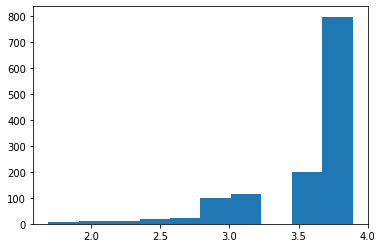

K-Means Clustering =====>

Cluster=3
Cluster 0: 1a 1998bw 1987a 
Cluster 1: 1996a 1998bw 1a 
Cluster 2: 1987a 1998bw 1a 
         citation_count
cluster                
0              2867.833
1              2264.353
2              4011.667

C (3, 4)


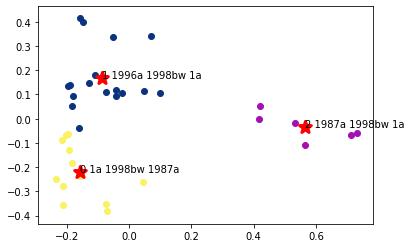


Cluster=6
Cluster 0: 1a 1996a 1998bw 1987a 
Cluster 1: 1987a 1998bw 1a 1996a 
Cluster 2: 1996a 1987a 1a 1998bw 
Cluster 3: 1998bw 1987a 1a 1996a 
Cluster 4: 1996a 1998bw 1a 1987a 
Cluster 5: 1a 1987a 1998bw 1996a 
         citation_count
cluster                
0              1690.714
1              4011.667
2              2583.222
3              4784.000
4              1909.333
5              2410.667

C (6, 4)


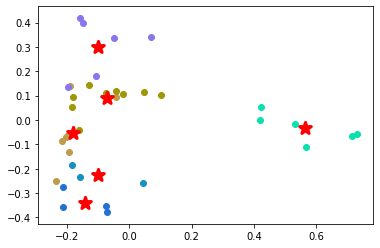


Cluster=8
Cluster 0: 1996a 1998bw 1a 1987a 
Cluster 1: 1987a 1a 1998bw 1996a 
Cluster 2: 1998bw 1987a 1a 1996a 
Cluster 3: 1a 1996a 1998bw 1987a 
Cluster 4: 1996a 1987a 1a 1998bw 
Cluster 5: 1987a 1996a 1998bw 1a 
Cluster 6: 1996a 1998bw 1a 1987a 
Cluster 7: 1a 1987a 1998bw 1996a 
         citation_count
cluster                
0              2213.750
1              5061.500
2              4784.000
3              1690.714
4              2608.750
5              1912.000
6              1660.000
7              2410.667

C (8, 4)


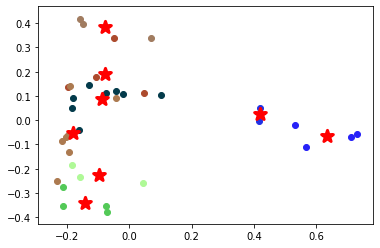


Cluster=10
Cluster 0: 1996a 1a 1998bw 1987a 
Cluster 1: 1987a 1a 1998bw 1996a 
Cluster 2: 1996a 1998bw 1a 1987a 
Cluster 3: 1a 1987a 1998bw 1996a 
Cluster 4: 1998bw 1987a 1a 1996a 
Cluster 5: 1a 1996a 1998bw 1987a 
Cluster 6: 1996a 1987a 1a 1998bw 
Cluster 7: 1996a 1998bw 1a 1987a 
Cluster 8: 1987a 1996a 1998bw 1a 
Cluster 9: 1996a 1987a 1998bw 1a 
         citation_count
cluster                
0              1953.000
1              5061.500
2              1660.000
3              2410.667
4              4784.000
5              1690.714
6              3947.333
7              2158.667
8              1912.000
9              1849.333

C (10, 4)


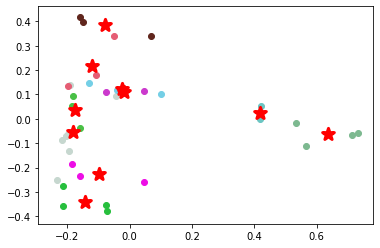


Cluster=15
Cluster 0: 1987a 1998bw 1a 1996a 
Cluster 1: 1996a 1a 1998bw 1987a 
Cluster 2: 1a 1996a 1998bw 1987a 
Cluster 3: 1998bw 1a 1987a 1996a 
Cluster 4: 1996a 1998bw 1a 1987a 
Cluster 5: 1996a 1998bw 1a 1987a 
Cluster 6: 1a 1987a 1998bw 1996a 
Cluster 7: 1996a 1998bw 1a 1987a 
Cluster 8: 1987a 1996a 1998bw 1a 
Cluster 9: 1a 1996a 1998bw 1987a 
Cluster 10: 1998bw 1987a 1996a 1a 
Cluster 11: 1996a 1987a 1a 1998bw 
Cluster 12: 1a 1998bw 1996a 1987a 
Cluster 13: 1996a 1987a 1998bw 1a 
Cluster 14: 1987a 1a 1998bw 1996a 
         citation_count
cluster                
0              3165.500
1              1924.000
2              1952.000
3              5578.000
4              2158.667
5              2088.000
6              2410.667
7              1446.000
8              1912.000
9              1596.000
10             3990.000
11             3947.333
12             1629.000
13             1849.333
14             6957.500

C (15, 4)


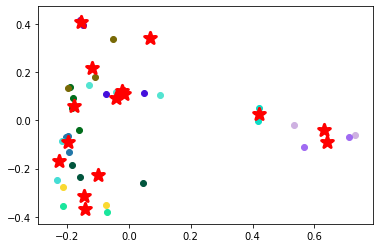


Cluster=25
Cluster 0: 1996a 1987a 1998bw 1a 
Cluster 1: 1a 1996a 1998bw 1987a 
Cluster 2: 1987a 1998bw 1a 1996a 
Cluster 3: 1998bw 1987a 1996a 1a 
Cluster 4: 1996a 1998bw 1a 1987a 
Cluster 5: 1996a 1a 1998bw 1987a 
Cluster 6: 1996a 1998bw 1a 1987a 
Cluster 7: 1998bw 1996a 1a 1987a 
Cluster 8: 1a 1987a 1998bw 1996a 
Cluster 9: 1996a 1987a 1a 1998bw 
Cluster 10: 1987a 1998bw 1a 1996a 
Cluster 11: 1987a 1996a 1998bw 1a 
Cluster 12: 1998bw 1a 1987a 1996a 
Cluster 13: 1996a 1998bw 1a 1987a 
Cluster 14: 1a 1998bw 1987a 1996a 
Cluster 15: 1a 1998bw 1987a 1996a 
Cluster 16: 1996a 1998bw 1a 1987a 
Cluster 17: 1a 1996a 1998bw 1987a 
Cluster 18: 1996a 1a 1998bw 1987a 
Cluster 19: 1987a 1a 1998bw 1996a 
Cluster 20: 1996a 1987a 1998bw 1a 
Cluster 21: 1998bw 1987a 1a 1996a 
Cluster 22: 1a 1998bw 1996a 1987a 
Cluster 23: 1998bw 1987a 1996a 1a 
Cluster 24: 1996a 1987a 1a 1998bw 
         citation_count
cluster                
0                2379.0
1                1771.5
2                3340.0
3  

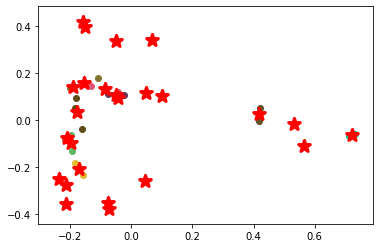

In [16]:
main()

In [ ]:
# cut dimensions
# make plot out of idf
# trunc citation count
# scatterplot with different colors
